In [1]:
import gymnasium as gym
import numpy as np
from enum import Enum
from dataclasses import dataclass
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

### I am choosing the B.2 Traffic Light Control

In [12]:
class TrafficLight:
    def __init__(self):
        self.states = ["Red", "Green", "Yellow"]
        self.current_state = { "North": "Red", "East": "Red", "South": "Red", "West": "Red" }
        self.previous_state = { "North": None, "East": None, "South": None, "West": None }
        self.active_direction = None  # Track which direction is Green or Yellow

    def change_signal(self, direction, new_state):
        # Prevent switching directly from Yellow to Green
        if self.previous_state[direction] == "Yellow" and new_state == "Green":
            raise ValueError(f"Illegal action: Cannot switch directly from Yellow to Green for {direction}")

        # Ensure only one Green or Yellow light at a time
        if new_state in ["Green", "Yellow"]:
            if self.active_direction is not None and self.active_direction != direction:
                raise ValueError(f"Cannot turn {direction} {new_state} while {self.active_direction} is Green or Yellow")
            self.active_direction = direction  # Set the active Green/Yellow direction

        elif new_state == "Red" and self.active_direction == direction:
            self.active_direction = None  # Reset active direction when it turns Red

        # Change the state of the direction
        self.previous_state[direction] = self.current_state[direction]
        self.current_state[direction] = new_state

        # If a direction is Green or Yellow, set all others to Red
        if new_state in ["Green", "Yellow"]:
            for dir in self.current_state:
                if dir != direction:
                    self.current_state[dir] = "Red"

    def get_current_state(self):
        return self.current_state

class TrafficSimulator:
    def __init__(self, deterministic=True):
        self.traffic = { "North": [], "East": [], "South": [], "West": [] }
        self.time_step = 0
        self.deterministic = deterministic

    def update_traffic(self):
        for direction in self.traffic:
            new_cars = 1 if self.deterministic else np.random.randint(0, 3)
            self.traffic[direction].extend([0] * new_cars)  

    def move_cars(self, lights):
        passed_cars = 0
        for direction, queue in self.traffic.items():
            if lights.current_state[direction] == "Green":
                to_remove = min(1, len(queue))
                passed_cars += to_remove
                self.traffic[direction] = queue[to_remove:]
        for direction in self.traffic:
            self.traffic[direction] = [time + 1 for time in self.traffic[direction]]
        return passed_cars

class TrafficEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = gym.spaces.MultiDiscrete([3] * 4)
        self.observation_space = gym.spaces.Box(low=0, high=50, shape=(4,), dtype=np.int32)
        self.lights = {"North": "Red", "East": "Red", "South": "Red", "West": "Red"}
        self.traffic = {"North": [], "East": [], "South": [], "West": []}
        self.time_limit = 100  

    def step(self, action):
        directions = ["North", "East", "South", "West"]
        for i, direction in enumerate(directions):
            self.lights[direction] = ["Red", "Green", "Yellow"][action[i]]

        reward = 0
        for direction in directions:
            if self.lights[direction] == "Green":
                passed_cars = min(3, len(self.traffic[direction]))
                self.traffic[direction] = self.traffic[direction][passed_cars:]
                reward += passed_cars * 5  

        for direction in directions:
            self.traffic[direction].extend([0] * np.random.randint(0, 3))

        waiting_penalty = sum(len(self.traffic[dir]) for dir in directions)
        reward -= waiting_penalty  

        done = self.time_limit <= 0
        self.time_limit -= 1

        return self._get_state(), reward, done, {}

    def reset(self):
        self.lights = {"North": "Red", "East": "Red", "South": "Red", "West": "Red"}
        self.traffic = {"North": [], "East": [], "South": [], "West": []}
        self.time_limit = 100
        return self._get_state()

    def _get_state(self):
        return np.array([len(self.traffic[dir]) for dir in ["North", "East", "South", "West"]])

    def render(self):
        """ Visualizes the intersection using a 4x4 grid in matplotlib. """
        fig, ax = plt.subplots(figsize=(6, 6))

        # Draw 4x4 Grid
        ax.set_xticks(np.arange(0, 5, 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(0, 5, 1) - 0.5, minor=True)
        ax.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
        ax.set_xlim(-0.5, 3.5)
        ax.set_ylim(-0.5, 3.5)

        # Light Colors
        color_map = {"Red": "red", "Green": "green", "Yellow": "yellow"}

        # Traffic Lights at intersections
        light_positions = {"North": (1.5, 3), "South": (1.5, 0), "East": (3, 1.5), "West": (0, 1.5)}
        for direction, (x, y) in light_positions.items():
            ax.add_patch(plt.Circle((x, y), 0.2, color=color_map[self.lights[direction]]))

        # Cars
        car_positions = {"North": (1.5, 2.5), "South": (1.5, 0.5), "East": (2.5, 1.5), "West": (0.5, 1.5)}
        for direction, (x, y) in car_positions.items():
            num_cars = len(self.traffic[direction])
            for i in range(min(num_cars, 3)):  
                ax.add_patch(plt.Rectangle((x - 0.1 * i, y - 0.1), 0.2, 0.2, color="blue"))

        # Labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

        plt.show()

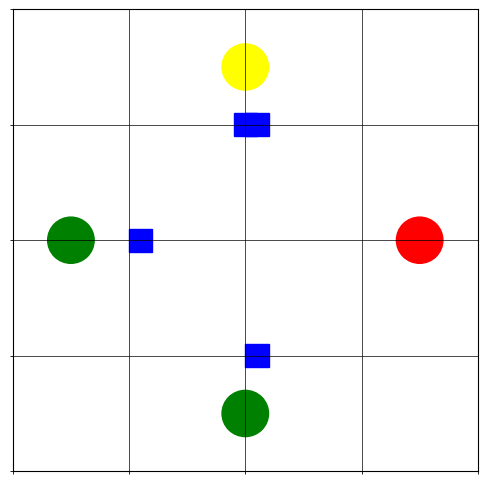

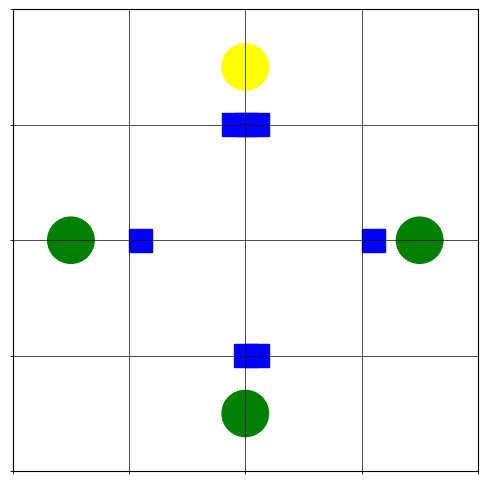

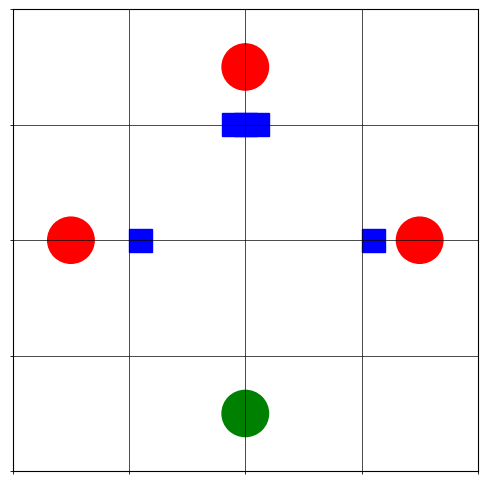

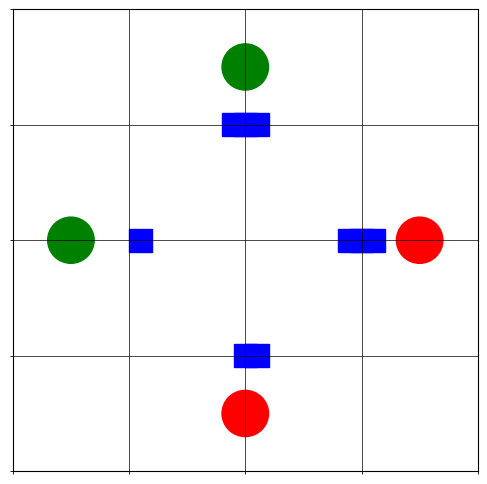

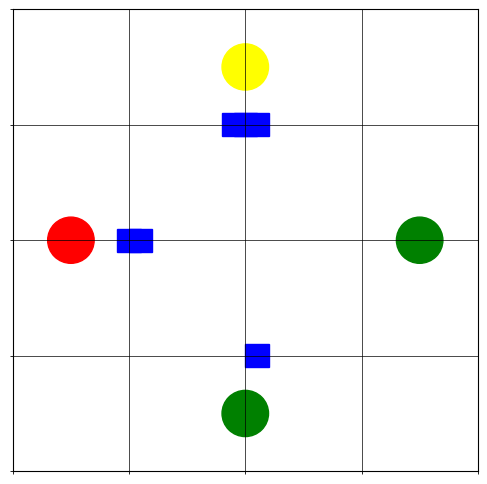

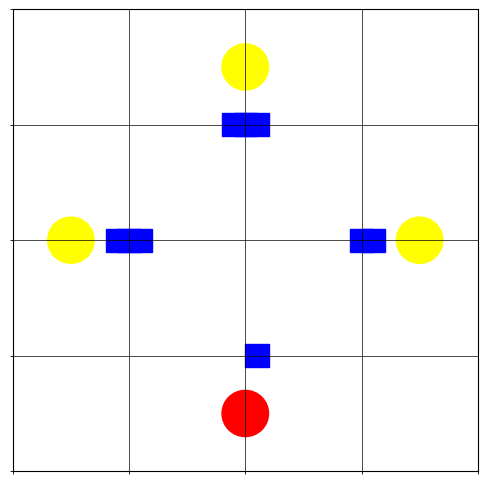

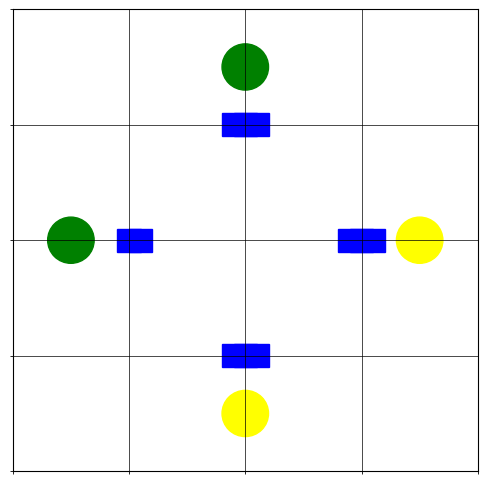

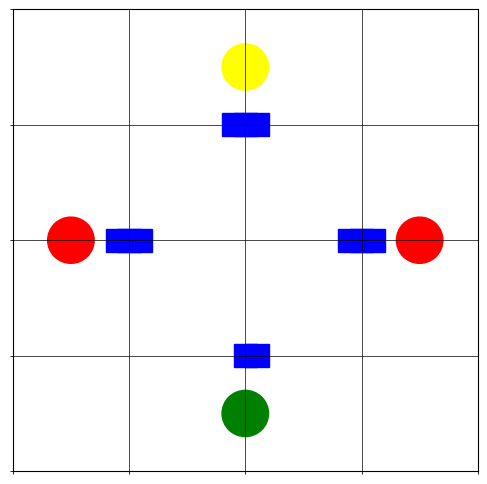

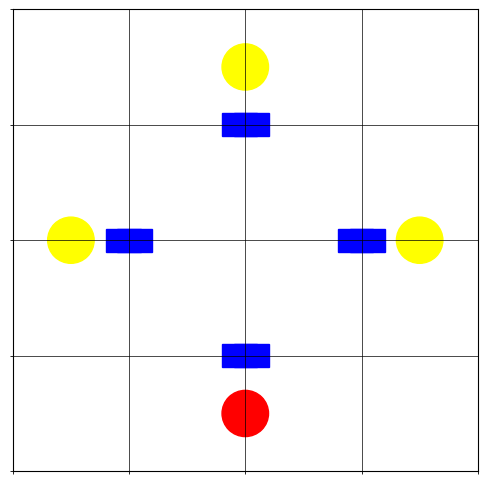

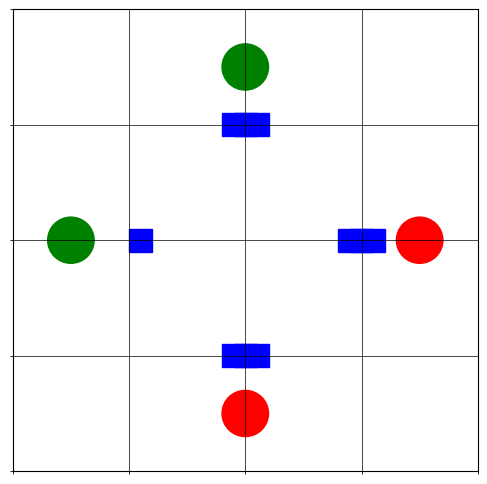

In [13]:
env = TrafficEnv()
state = env.reset()

for _ in range(10):
    action = env.action_space.sample()  # Random action
    state, reward, done, _ = env.step(action)
    env.render()